## Crossentropy Method

В этой пункте мы посмотрим на то, как решить задачи RL с помощью метода crossentropy.

Рассмотрим пример с задачей Taxi [Dietterich, 2000](https://arxiv.org/pdf/cs/9905014.pdf). 

In [1]:
try:
    import colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !pip install "gymnasium[classic-control, atari, accept-rom-license]" --quiet
    !apt-get install python-opengl -y -qq
    !apt-get install xvfb -y -qq
    !pip install pyvirtualdisplay --quiet
    !pip install piglet --quiet
    !pip install imageio_ffmpeg --quiet
    !pip install moviepy==1.0.3 --quiet
    !wget https://gist.githubusercontent.com/Tviskaron/d91decc1ca5f1b09af2f9f080011a925/raw/0d3474f65b4aea533996ee00edf99a37e4da5561/colab_render.py -O colab_render.py -q 
    import colab_render

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 KB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 13.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 71.6 MB/s eta 0:00:00
Selecting previously unselected package python2-minimal.
(Reading database ... 128048 files and directories currently installed.)
Preparing to unpack .../python2-minimal_2.7.17-2ubuntu4_amd64.deb ...
Unpacking python2-minimal (2.7.17-2ubuntu4) ...
Selecting previously unselected package libpython2-stdlib:amd64.
Preparing to unpack .../libpython2-stdlib_2.7.17-2ubuntu4_amd64.deb ...
Unpacking libpython2-stdlib:amd64 (2.7.17-2ubuntu4) ...
Setting up python2-minimal (2.7.17-2ubuntu4) ...
Selecting previously unselected package python2.
(Reading database ... 128077 files and directories currently installed.)
Preparing to

In [2]:
import glob
import io
import base64
from IPython import display as ipythondisplay
from IPython.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline

def show_video(folder="./video"):
    mp4list = glob.glob(folder + '/*.mp4')
    if len(mp4list) > 0:
        mp4 = sorted(mp4list, key=lambda x: x[-15:], reverse=True)[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

/usr/local/lib/python3.8/dist-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/usr/local/lib/python3.8/dist-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Overriding environment GymV22Environment-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


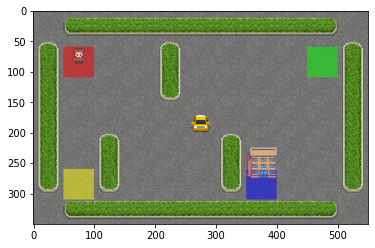

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gymnasium as gym

env = gym.make("Taxi-v3", render_mode="rgb_array")
env.reset()
plt.imshow(env.render())

In [ ]:
n_states  = env.observation_space.n
n_actions = env.action_space.n  

print(f"состояний: {n_states} действий: {n_actions}")

состояний: 500 действий: 6


В этот раз нашей стратегией будет вероятностной распределение. 

$\pi(s,a) = P(a|s)$

Для задачи такси мы можем использовать таблицу: 

policy[s,a] = P(выбрать действие a | в состоянии s)

Создадим "равномерную" стратегию в виде двумерного массива с 
равномерным распределением по действиям и сгенерируем игровую сессию с такой стратегией

In [ ]:
def initialize_policy(n_states, n_actions):
    ####### Здесь ваш код ########
    policy = np.ones((n_states, n_actions), dtype = np.float32) / n_actions
    ##############################
    return policy

policy = initialize_policy(n_states, n_actions)

In [ ]:
assert type(policy) in (np.ndarray, np.matrix)
assert np.allclose(policy, 1./n_actions)
assert np.allclose(np.sum(policy, axis=1), 1)

### Генерация сессий взаимодейтсвия со средой.

Мы будем запоминать все состояния, действия и вознаграждения за эпизод.

In [ ]:
def generate_session(env, policy, t_max=10**4):
    """
    Игра идет до конца эпизода или до t_max шагов в окружении. 
    :param policy: [n_states, n_actions] 
    :returns: states - список состояний, actions - список действий, total_reward - итоговое вознаграждение
    """
    states, actions = [], []
    total_reward = 0.

    s, info = env.reset()

    for t in range(t_max):
        # Подсказка: вы можете использовать np.random.choice для сэмплирования
        # https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html
        # a = 
        ####### Здесь ваш код ########
        a = np.random.choice(n_actions, p = policy[s])
        ##############################
        new_s, r, terminated, truncated, info = env.step(a)

        # Записываем информацию, который мы получили от среды.
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if terminated:
            break

    return states, actions, total_reward

In [ ]:
s, a, r = generate_session(env, policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert isinstance(r, float)

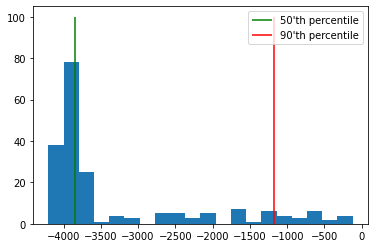

In [ ]:
# посмотрим на изначальное распределение вознаграждения
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session(env, policy, t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards, bins=20)
plt.vlines([np.percentile(sample_rewards, 50)], [0], [100], label="50'th percentile", color='green')
plt.vlines([np.percentile(sample_rewards, 90)], [0], [100], label="90'th percentile", color='red')
plt.legend()

### Реализация метода crossentropy  

Наша задача - выделить лучшие действия и состояния, т.е. такие, при которых было лучшее вознаграждение:

In [ ]:
def select_elites(states_batch, actions_batch, 
                  rewards_batch, percentile=50):
    """
    Выбирает состояния и действия с заданным перцентилем (rewards >= percentile)
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]
    
    :returns: elite_states, elite_actions - одномерные 
    списки состояния и действия, выбранных сессий
    """
    # нужно найти порог вознаграждения по процентилю
    # reward_threshold =
    ####### Здесь ваш код ########
    reward_threshold = np.percentile(rewards_batch, q = percentile)
    ##############################
    
    
    # в соответствии с найденным порогом - заполнить списки 
    # elite_states и elite_actions, нужными состояниями и действиями
    ####### Здесь ваш код ########
    elite_states = [s[t] for ind, s in enumerate(states_batch) if rewards_batch[ind] >= reward_threshold for t in range(len(s))]    
    elite_actions = [a[t] for ind, a in enumerate(actions_batch) if rewards_batch[ind] >= reward_threshold  for t in range(len(a))]
    ##############################
    
    return elite_states, elite_actions

In [ ]:
states_batch = [
    [1, 2, 3],     # game1
    [4, 2, 0, 2],  # game2
    [3, 1],        # game3
]

actions_batch = [
    [0, 2, 4],     # game1
    [3, 2, 0, 1],  # game2
    [3, 3],        # game3
]
rewards_batch = [
    3,  # game1
    4,  # game2
    5,  # game3
]

test_result_0 = select_elites(states_batch, actions_batch, rewards_batch, percentile=0)
test_result_30 = select_elites(states_batch, actions_batch, rewards_batch, percentile=30)
test_result_90 = select_elites(states_batch, actions_batch, rewards_batch, percentile=90)
test_result_100 = select_elites(states_batch, actions_batch, rewards_batch, percentile=100)

assert np.all(
    test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1]) \
       and np.all(
    test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]), \
    "Для процентиля 0 необходимо выбрать все состояния " \
    "и действия в хронологическом порядке"

assert np.all(test_result_30[0] == [4, 2, 0, 2, 3, 1])\
   and np.all(test_result_30[1] == [3, 2, 0, 1, 3, 3]), \
    "Для процентиля 30 необходимо выбрать " \
    "состояния/действия из [3:]"
assert np.all(test_result_90[0] == [3, 1]) and \
       np.all(test_result_90[1] == [3, 3]), \
    "Для процентиля 90 необходимо выбрать состояния " \
    "действия одной игры"
assert np.all(test_result_100[0] == [3, 1]) and \
       np.all(test_result_100[1] == [3, 3]), \
    "Проверьте использование знаков: >=,  >. " \
    "Также проверьте расчет процентиля"
print("Тесты пройдены!")


Тесты пройдены!


Теперь мы хотим написать обновляющуюся стратегию:

In [ ]:
def update_policy(elite_states, elite_actions):
    """
    Новой стратегией будет:
    policy[s_i,a_i] ~ #[вхождения  si/ai в лучшие states/actions]
    
    Не забудьте про нормализацию состояний.
    Если какое-то состояние не было посещено, 
    то используйте равномерное распределение 1./n_actions
    
    :param elite_states:  список состояний
    :param elite_actions: список действий
    """
    new_policy = np.zeros([n_states, n_actions], dtype = np.float32)
    
    # обновляем стратегию - нормируем новые частоты
    # действий и не забываем про непосещенные состояния     
    ####### Здесь ваш код ########
    occurences = np.zeros(n_states)
      
    for index,state in enumerate(elite_states):
        new_policy[state, elite_actions[index]] += 1 
        occurences[state] += 1
        
    for idx in range(n_states):
        if occurences[idx] == 0:
            new_policy[idx,:] = 1./ n_actions
        else:
            new_policy[idx,:] /= occurences[idx]
    
    ##############################
    return new_policy

In [ ]:
elite_states, elite_actions = (
    [1, 2, 3, 4, 2, 0, 2, 3, 1],
    [0, 2, 4, 3, 2, 0, 1, 3, 3])

new_policy = update_policy(elite_states, elite_actions)
print(new_policy[:4, :5])

assert np.isfinite(
    new_policy).all(), "Стратегия не должна содержать " \
                       "NaNs или +-inf. Проверьте " \
                       "деление на ноль. "
assert np.all(
    new_policy >= 0), "Стратегия не должна содержать " \
                      "отрицательных вероятностей "
assert np.allclose(new_policy.sum(axis=-1),
                   1), "Суммарная вероятность действий"\
                       "для состояния должна равняться 1"
reference_answer = np.array([
    [1., 0., 0., 0., 0.],
    [0.5, 0., 0., 0.5, 0.],
    [0., 0.33333333, 0.66666667, 0., 0.],
    [0., 0., 0., 0.5, 0.5]])

assert np.allclose(new_policy[:4, :5], reference_answer)
print("Тесты пройдены!")

[[1.         0.         0.         0.         0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.33333334 0.6666667  0.         0.        ]
 [0.         0.         0.         0.5        0.5       ]]
Тесты пройдены!


### Цикл обучения

Визуализириуем наш процесс обучения и также будем измерять распределение получаемых за сессию вознаграждений 

In [ ]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    Удобная функция, для визуализации результатов.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])
    
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()
    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.show()

In [ ]:
# инициализируем стратегию
policy = initialize_policy(n_states, n_actions)

mean reward = -43.936, threshold=6.000


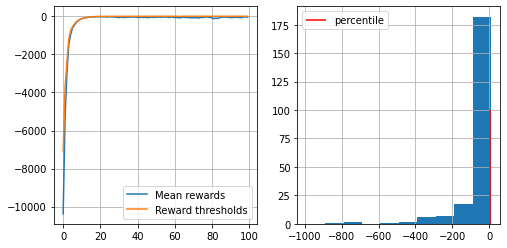

In [ ]:
n_sessions = 250  # количество сессий для сэмплирования
percentile = 50  # перцентиль 
learning_rate = 0.5 # то как быстро стратегия будет обновляться 

log = []

for i in range(100):
    # генерируем n_sessions сессий
    # sessions = []
    ####### Здесь ваш код ########
    sessions = [generate_session(env, policy = policy) for _ in range(n_sessions)]
    ##############################
    
    states_batch, actions_batch, rewards_batch = zip(*sessions)
    # отбираем лучшие действия и состояния ###
    # elite_states, elite_actions = 
    ####### Здесь ваш код ########
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    ##############################
    
    # обновляем стратегию
    # new_policy =
    ####### Здесь ваш код ########
    new_policy = update_policy(elite_states, elite_actions)
    ##############################
    
    policy = learning_rate * new_policy + (1 - learning_rate) * policy

    # выводим график с результатами
    show_progress(rewards_batch, log, percentile)

### Посмотрим на результаты
Задача такси быстро сходится, начиная с вознаграждения -1000 к почти оптимальному значению, а потом опять падает до -50/-100. Это вызвано случайностью в самом окружении $-$ случайное начальное состояние пассажира и такси, в начале каждого эпизода. 

В случае если алгоритм CEM не сможет научиться тому, как решить задачу из какого-то стартового положения, он просто отбросит этот эпизод, т.к. не будет сессий, которые переведут этот эпизод в топ лучших. 

Для решения этой проблемы можно уменьшить threshold (порог лучших состояний) или изменить способ оценки стратегии, используя новую стратегию, полученную из каждого начального состояния и действия (теоретически правильный способ).

## Deep CEM. Закапываемся глубже.

В данной части мы рассмотрим применение CEM вместе с нейронной сетью.
Будем обучать многослойную нейронную сеть для решения простой задачи с непрерывным пространством действий.

<img src="https://raw.githubusercontent.com/Tviskaron/mipt/master/2020/RL/figures/digging.svg">

Будем тестировать нашего нового агента на известной задаче перевернутого маятника, с непрерывным пространством состояний.
https://gym.openai.com/envs/CartPole-v0/

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]
                                        
print(f"состояний: {state_dim} действий: {n_actions}")

состояний: 4 действий: 2


### Стратегия с нейронной сетью

Попробуем заменить метод обновления вероятностей на нейронную сеть. 
Будем пользоваться упрощенной реализацией нейронной сети из пакета Scikit-learn.
Нам потребуется: 
* agent.partial_fit(states, actions) - делает один проход обучения по данным. Максимизирует вероятность :actions: из :states:
* agent.predict_proba(states) - предсказыает вероятность каждого из действий, в виде матрицы размера [len(states), n_actions]

In [ ]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
)

# инициализируем агента под заданное пространство состояний и действий
agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

In [ ]:
def generate_session(env, agent, t_max=1000):
    
    states,actions = [],[]
    total_reward = 0
    
    s, info = env.reset()
    
    for t in range(t_max):
        # предсказываем вероятности действий по сети и 
        # выбираем одно действие
        # probs = 
        # a = 
        ####### Здесь ваш код ########
        probs = agent.predict_proba([s])[0] 
        a = np.random.choice(n_actions, p=probs)
        ##############################
        
        new_s, r, terminated, truncated, info = env.step(a)
        
        states.append(s)
        actions.append(a)
        total_reward+=r
        
        s = new_s
        if terminated:
            break
    return states, actions, total_reward

In [ ]:
dummy_states, dummy_actions, dummy_reward = generate_session(env, agent, t_max=5)
print("состояния:", np.stack(dummy_states))
print("действия:", dummy_actions)
print("вознаграждение:", dummy_reward)

состояния: [[ 0.01274693 -0.04462199 -0.00751519  0.02378026]
 [ 0.01185449 -0.23963536 -0.00703959  0.31408262]
 [ 0.00706178 -0.04441384 -0.00075794  0.01918797]
 [ 0.0061735   0.15071897 -0.00037418 -0.273734  ]
 [ 0.00918788 -0.04439764 -0.00584886  0.01883089]]
действия: [0, 1, 1, 0, 0]
вознаграждение: 5.0


mean reward = 197.875, threshold=187.500


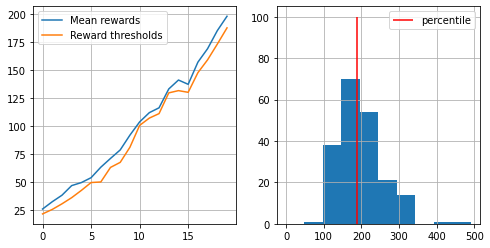

Принято!


In [ ]:
n_sessions = 200
percentile = 50
log = []

for i in range(100):
    sessions = [generate_session(env, agent) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = map(list, zip(*sessions))
    elite_states, elite_actions = select_elites(states_batch,actions_batch,rewards_batch, percentile)
    
    # учим стратегию предсказывать в состояниях X=elite_states, 
    # действия y=elite_actions 
    ####### Здесь ваш код ########
    agent.partial_fit(elite_states, elite_actions, range(n_actions))
    ##############################
    
    show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])

    if np.mean(rewards_batch) > 190:
        print("Принято!")
        break


In [ ]:
env.close()

In [ ]:
from gymnasium.wrappers.record_video import RecordVideo

env = gym.make("CartPole-v1", render_mode="rgb_array")
env = RecordVideo(env, "./video")

generate_session(env, agent)

env.close()
show_video()

In [3]:
!pip install -U --quiet jax jaxlib flax wandb chex optax jumanji
%env JAX_ENABLE_X64=True

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 KB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 76.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.2/77.2 KB 8.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 KB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 KB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [16]:
# https://github.com/udacity/deep-reinforcement-learning/blob/master/cross-entropy/CEM.ipynb
import flax, jax
import jax.numpy as jnp
import flax.linen as nn
import chex
from typing import Literal, Sequence, List, Union
from collections import deque

class MLP(nn.Module):
  """
  A simple MLP
  """
  features: Sequence[int]
  action_type: Union["discrete", "continuos"] = "continuos"

  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
        x = nn.relu(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1])(x)
    if self.action_type == "discrete":
        x = nn.activation.log_softmax(x, axis = -1)
        return jnp.argmax(x, axis = -1)
    elif self.action_type == "continuos":
        x = nn.activation.tanh(x)
        return x


@chex.dataclass
class Agent(nn.Module):
    state_dim: int
    action_dim: int
    hidden_dim: int
    num_layers: int
    action_type: Union["discrete", "continuos"] = "discrete"

    def num_parameters(self, state_dim: int) -> int:
        layer_dims = jnp.array([self.state_dim] + [self.hidden_dim] * self.num_layers + [self.action_dim])
        p = jnp.sum(layer_dims[1:])
        for w1, w2 in zip(layer_dims[:-1], layer_dims[1:]): 
            p += w1 * w2
        return p
    
    def transfer_weights(self, variables, pretrained_weights):
        #https://github.com/google/flax/discussions/923
        variables = flax.core.unfreeze(variables)
        variables["params"].update(pretrained_weights)
        variables = flax.core.freeze(variables) 
        return variables
        
    @nn.compact
    def __call__(self, x):
        out = MLP([self.hidden_dim] * self.num_layers + [self.action_dim], self.action_type)(x) 
        return out

    def evaluate(self, weights, eval_env, gamma: float = 1.0, T: int = 5000) -> dict:
        variables = self.transfer_weights(variables, weights)
        episode_return = 0.0
        state = self.env.reset()
        for t in range(T):
            action = agent.apply(variables, jnp.array(state).unsqueeze(0))
            state, reward, done, _ = self.eval_env.step(action)
            episode_return += reward * gamma ** t
            if done:
                break
        return {"episode_return": episode_return}
    


In [12]:
# test
model = MLP([12, 8, 8, 4])
batch = jnp.ones((32, 10))
variables = model.init(jax.random.PRNGKey(0), batch)
output = model.apply(variables, batch)
print(jax.tree_map(lambda x: x.shape, variables["params"]))

FrozenDict({
    Dense_0: {
        bias: (12,),
        kernel: (10, 12),
    },
    Dense_1: {
        bias: (8,),
        kernel: (12, 8),
    },
    Dense_2: {
        bias: (8,),
        kernel: (8, 8),
    },
    Dense_3: {
        bias: (4,),
        kernel: (8, 4),
    },
})


In [13]:
# test
from copy import deepcopy
agent = Agent(hidden_dim = 3, action_dim = 10, num_layers = 3)
batch = jnp.ones((32, 10))
variables = agent.init(jax.random.PRNGKey(0), batch)
vvv = deepcopy(flax.core.unfreeze(variables["params"]))
vvv = jax.tree_map(lambda x: x + 10.01, vvv)
variables  = agent.transfer_weights(variables, vvv)
output = agent.apply(variables, batch)
print(jax.tree_map(lambda x: x.shape, variables["params"]))
print("number of parameters:", agent.num_parameters(10))

FrozenDict({
    MLP_0: {
        Dense_0: {
            bias: (3,),
            kernel: (10, 3),
        },
        Dense_1: {
            bias: (3,),
            kernel: (3, 3),
        },
        Dense_2: {
            bias: (3,),
            kernel: (3, 3),
        },
        Dense_3: {
            bias: (10,),
            kernel: (3, 10),
        },
    },
})
number of parameters: 97


In [15]:
def cem(agent: Agent, n_iterations: int = 500, T: int = 1000, gamma: float = 1.0, print_every: int = 10, pop_size: int = 50, elite_frac: float = 0.2, sigma: float =0.5, seed: int = 42):
    """PyTorch implementation of the cross-entropy method.
        
    Params
    ======
        n_iterations (int): maximum number of training iterations
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        pop_size (int): size of population at each iteration
        elite_frac (float): percentage of top performers to use in update
        sigma (float): standard deviation of additive noise
    """
    assert (
        0 <= gamma <=1 and
        0 < elite_frac < 1
    )
    n_elite=int(pop_size*elite_frac)

    scores_deque = deque(maxlen=100)
    scores = []
    main_rng = jax.random.PRNGKey(seed)
    next_rng, noise_rng = jax.random.split(main_rng, 2)
    best_weight = sigma*jax.random.normal(noise_rng, shape = agent.num_parameters())

    for i_iteration in range(1, n_iterations+1):
        weights_pop = [best_weight + (sigma*np.random.randn(agent.get_weights_dim())) for i in range(pop_size)]
        rewards = jnp.array([agent.evaluate(weights, gamma, T) for weights in weights_pop])

        elite_idxs = rewards.argsort()[-n_elite:]
        elite_weights = [weights_pop[i] for i in elite_idxs]
        best_weight = jnp.array(elite_weights).mean(axis=0)

        reward = agent.evaluate(best_weight, gamma = gamma)
        scores_deque.append(reward)
        scores.append(reward)
        
        # torch.save(agent.state_dict(), 'checkpoint.pth')
        
        if i_iteration % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))

        if np.mean(scores_deque)>=90.0:
            print('\nEnvironment solved in {:d} iterations!\tAverage Score: {:.2f}'.format(i_iteration-100, np.mean(scores_deque)))
            break
    return scores

scores = cem()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

NameError: ignored

In [ ]:
import jax
import gymnax

rng = jax.random.PRNGKey(1234)
rng, key_reset, key_act, key_step = jax.random.split(rng, 4)

# Instantiate the environment & its settings.
env, env_params = gymnax.make("CartPole-v1")

# Reset the environment.
obs, state = env.reset(key_reset, env_params)

# Sample a random action.
action = env.action_space(env_params).sample(key_act)

# Perform the step transition.
n_obs, n_state, reward, done, _ = env.step(key_step, state, action, env_params)

In [ ]:
def rollout(rng_input, policy_params, env_params, steps_in_episode):
    """Rollout a jitted gymnax episode with lax.scan."""
    # Reset the environment
    rng_reset, rng_episode = jax.random.split(rng_input)
    obs, state = env.reset(rng_reset, env_params)

    def policy_step(state_input, tmp):
        """lax.scan compatible step transition in jax env."""
        obs, state, policy_params, rng = state_input
        rng, rng_step, rng_net = jax.random.split(rng, 3)
        action = model.apply(policy_params, obs)
        next_obs, next_state, reward, done, _ = env.step(
            rng_step, state, action, env_params
        )
        carry = [next_obs, next_state, policy_params, rng]
        return carry, [obs, action, reward, next_obs, done]

    # Scan over episode step loop
    _, scan_out = jax.lax.scan(
        policy_step,
        [obs, state, policy_params, rng_episode],
        (),
        steps_in_episode
    )
    # Return masked sum of rewards accumulated by agent in episode
    obs, action, reward, next_obs, done = scan_out
    return obs, action, reward, next_obs, done

Array(1., dtype=float32, weak_type=True)